In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Set random seed
np.random.seed(0)

# Generate Synthetic Data
data_size = 20

data = {
    'Country': np.random.choice(['France', 'Spain', 'Germany'], data_size),
    'Age': np.random.randint(25, 50, data_size),
    'Salary': np.random.randint(30000, 90000, data_size),
    'Purchased': np.random.choice(['No', 'Yes'], data_size) # The Target Variable
}

df = pd.DataFrame(data)

# Introduce a scale problem:
# 'Age' is small (20-50), 'Salary' is huge (30k-90k).
# Most ML models will accidentally think Salary is more important just because the number is bigger.

print("--- Original Raw Data ---")
display(df.head())

--- Original Raw Data ---


,Country,Age,Salary,Purchased
0,France,33,46321,No
1,Spain,34,82489,No
2,France,45,49129,No
3,Spain,44,83887,Yes
4,Spain,41,71504,Yes


In [2]:
# X = df[['Country', 'Age', 'Salary']]
X = df.iloc[:, :-1]

y = df['Purchased']

print("--- Features (X) ---")
print(X.head())
print("\n--- Target (y) ---")
print(y.head())

--- Features (X) ---
  Country  Age  Salary
0  France   33   46321
1   Spain   34   82489
2  France   45   49129
3   Spain   44   83887
4   Spain   41   71504

--- Target (y) ---
0     No
1     No
2     No
3    Yes
4    Yes
Name: Purchased, dtype: object


Machines do not understand text strings like "France" or "Germany". We must convert them to numbers.

- Label Encoding: Converts "No/Yes" to 0/1. Good for the target variable y.

- One-Hot Encoding: Converts "France/Spain" into separate columns of 0s and 1s. Good for features X to avoid ranking countries (e.g., avoiding France < Germany).

In [3]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Encode the categorial features
X_encoded = pd.get_dummies(X, columns=['Country'])

print("\n--- Encoded Features ---")
display(X_encoded.head())


--- Encoded Features ---


,Age,Salary,Country_France,Country_Germany,Country_Spain
0,33,46321,True,False,False
1,34,82489,False,False,True
2,45,49129,True,False,False
3,44,83887,False,False,True
4,41,71504,False,False,True


We never train the model on 100% of the data, or we won't know if it actually works on new data. We standardly split 80% for Training and 20% for Testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

print(f"Total Rows: {len(df)}")
print(f"Training Rows: {len(X_train)}")
print(f"Testing Rows: {len(X_test)}")

Total Rows: 20
Training Rows: 16
Testing Rows: 4


This is the most common beginner mistake. Because Salary (50,000) is mathematically much larger than Age (30), the model will be biased. We map them to the same scale (usually between -3 and 3).

- Crucial Rule: We fit the scaler ONLY on the Training set, then transform the Test set. This prevents "Data Leakage" (cheating by peaking at the test data stats).

In [5]:
# Feature Scaling
scaler = StandardScaler()

# Fit on training set, then transform it
X_train_scaled = scaler.fit_transform(X_train)

# ONLY transform the test set (do not fit!)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier viewing
X_train_final = pd.DataFrame(X_train_scaled, columns=X_encoded.columns)

print("--- Scaled Training Data ---")
display(X_train_final.head())
# Notice: Age and Salary are now small decimals (Z-scores).
# This makes it easy for the model to learn patterns.

--- Scaled Training Data ---


,Age,Salary,Country_France,Country_Germany,Country_Spain
0,0.199337,1.235234,1.48324,-0.67420,-0.774597
1,0.730901,1.141520,-0.67420,1.48324,-0.774597
2,-1.395357,0.465322,-0.67420,1.48324,-0.774597
3,0.730901,1.031056,-0.67420,-0.67420,1.290994
4,-0.863792,-0.682614,-0.67420,-0.67420,1.290994


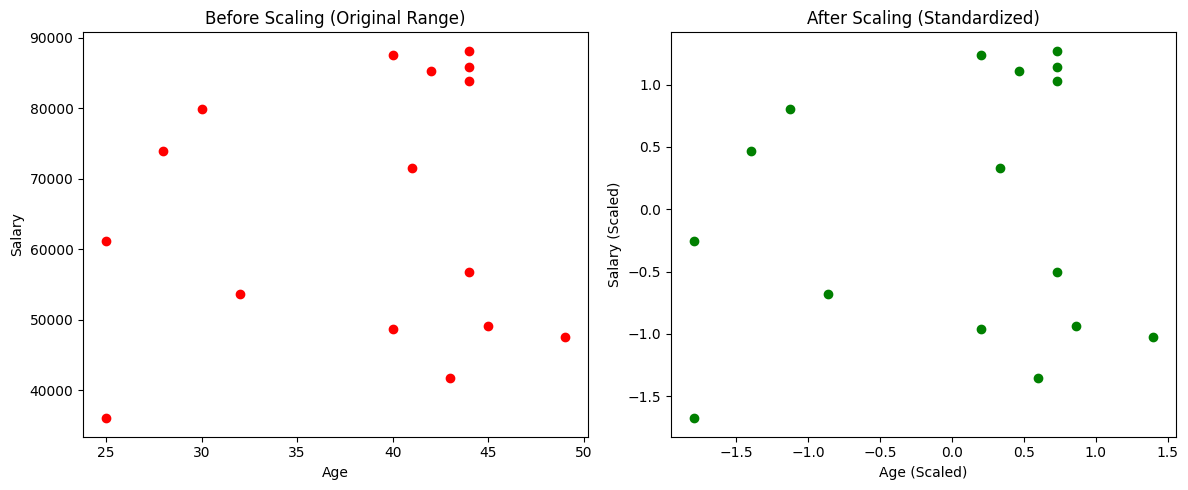

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Original Data (Age vs Salary)
# Note: Points will be very spread out vertically due to high Salary
ax[0].scatter(X_train['Age'], X_train['Salary'], color='red')
ax[0].set_title("Before Scaling (Original Range)")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Salary")

# Plot Scaled Data
# Note: The shape is identical, but the axis values are centered around 0
ax[1].scatter(X_train_final['Age'], X_train_final['Salary'], color='green')
ax[1].set_title("After Scaling (Standardized)")
ax[1].set_xlabel("Age (Scaled)")
ax[1].set_ylabel("Salary (Scaled)")

plt.tight_layout()
plt.show()

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(X_train_scaled, y_train)

In [8]:
clf.predict(X_test_scaled)

array([1, 1, 0, 1])

In [9]:
y_test

array([0, 0, 1, 0])

In [10]:
clf.predict(X_train_scaled)

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [11]:
y_train

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1])